In [13]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2
from utils.imutils import displayImage
import pandas as pd

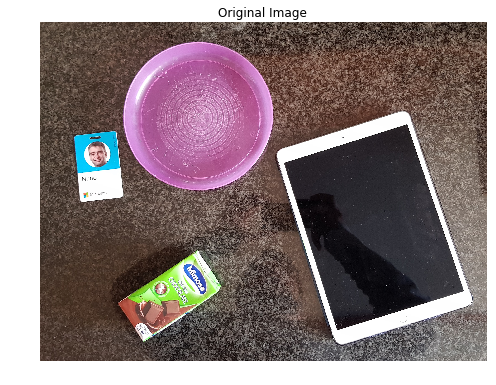

In [14]:
image = cv2.imread('images/sizes.jpg')
displayImage(image, title='Original Image')

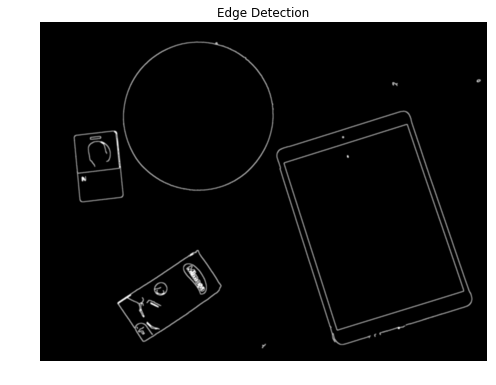

In [15]:
# grayscale and blur
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (13, 13), 0)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 20, 220)
edged = cv2.dilate(edged, None, iterations=2)
edged = cv2.erode(edged, None, iterations=1)
displayImage(edged, title="Edge Detection")

In [16]:
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts, method='left-to-right')
pixelsPerMetric = None

In [17]:
print("All contours:", len(cnts))

# get areas for all contours
areas = []
for c in cnts:
    a = cv2.contourArea(c)
    areas.append(a)
    
areas = np.array(areas)
cnts = np.array(cnts)

# remove small contours
cnts = cnts[np.where(areas >= 600)[0]]
print("Big contours:", len(cnts))

# remove areas of removed contours
areas = areas[np.where(areas >= 600)[0]]

All contours: 11
Big contours: 5


In [18]:
# loop over the contours individually and get bounding boxes
boxes = []
for c in cnts:
    
    # compute the rotated bounding box of the contour
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box) 
    box = np.array(box, dtype="int")
 
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    boxes.append(box)

boxes = np.array(boxes)
print("Found {} contours".format(len(boxes)))

Found 5 contours


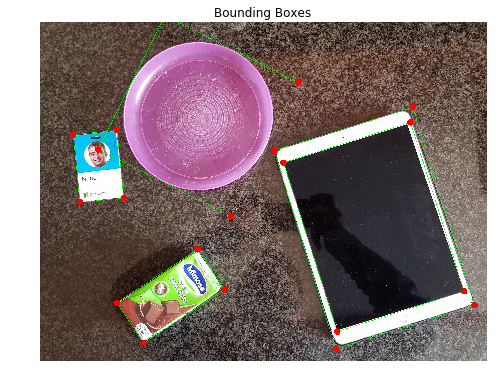

In [19]:
orig = image.copy()

for b in boxes:
    cv2.drawContours(orig, [b.astype("int")], -1, (0, 255, 0), 2)
    for (x, y) in b:
        cv2.circle(orig, (int(x), int(y)), 20, (0, 0, 255), -1)

displayImage(orig, title="Bounding Boxes")

In [20]:
def checkEnvolvingBox(box, area, allBoxes, allBoxesAreas):
    #get minX, maxX, minY and maxY for the box
    maxX, maxY = np.max(box, axis=0)
    minX, minY = np.min(box, axis=0)
   
    for lb in allBoxes:
        lbmaxX, lbmaxY = np.max(lb, axis=0)
        lbminX, lbminY = np.min(lb, axis=0)
        result = (minX > lbminX) & (maxX < lbmaxX) & (minY > lbminY) & (maxY < lbmaxY)
        if result:
            return True
    return False

boxes_to_keep = []
# remove inner contours
for i in range(len(boxes)):
    if not checkEnvolvingBox(boxes[i], areas[i], boxes, areas):
        boxes_to_keep.append(i)


boxes = boxes[boxes_to_keep]
print(len(boxes))

4


## Calculate Sizes

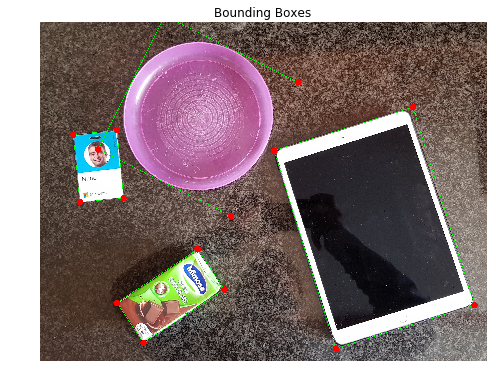

In [21]:
orig = image.copy()

for b in boxes:
    cv2.drawContours(orig, [b.astype("int")], -1, (0, 255, 0), 2)
    for (x, y) in b:
        cv2.circle(orig, (int(x), int(y)), 20, (0, 0, 255), -1)
        
displayImage(orig, title="Bounding Boxes")

In [22]:
knownWidth = 5.4

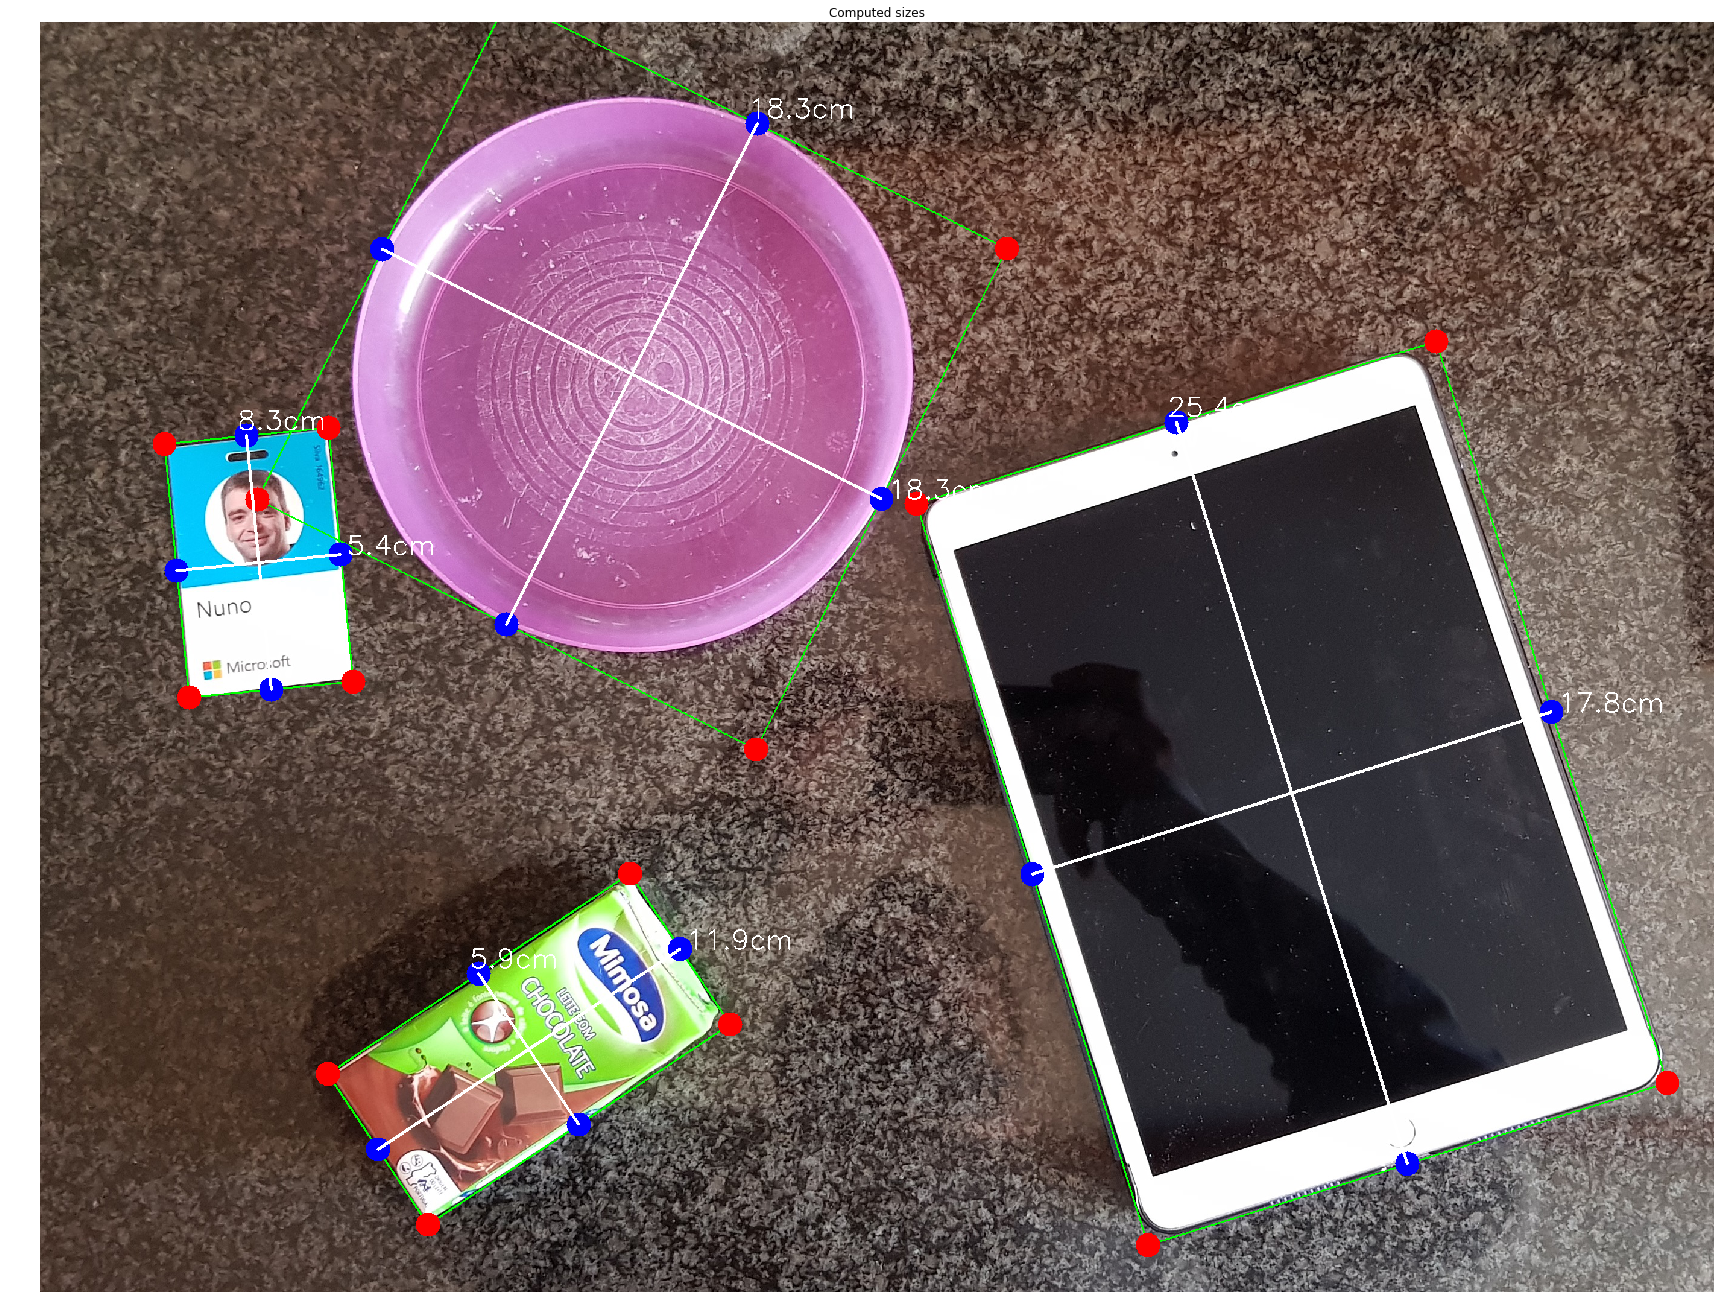

In [23]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

object_sizes = []

for box in boxes:
    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
 
    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
 
    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 20, (255,0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 20, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 20, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 20, (255, 0, 0), -1)
 
    # draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 255, 255), 4)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 255, 255), 4)
    
    # compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
    # if the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric
    # (in this case, inches)
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / knownWidth
    
    # compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric
 
    object_sizes.append([box, dimA, dimB])

    # draw the object sizes on the image
    cv2.putText(orig, "{:.1f}cm".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(orig, "{:.1f}cm".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
        
displayImage(orig, figSize=(30,30), title='Computed sizes')

In [24]:
print(object_sizes)

[[8.348223425200143, 5.4, array([[  206.,   699.],
       [  478.,   672.],
       [  519.,  1093.],
       [  247.,  1119.]], dtype=float32)], [5.929659552431239, 11.875785168861901, array([[  477.,  1743.],
       [  978.,  1411.],
       [ 1144.,  1661.],
       [  643.,  1993.]], dtype=float32)], [18.331668003302198, 18.278643750360466, array([[  775.,   -38.],
       [ 1603.,   375.],
       [ 1187.,  1205.],
       [  360.,   791.]], dtype=float32)], [25.439111404045377, 17.833250388752475, array([[ 1453.,   798.],
       [ 2315.,   529.],
       [ 2698.,  1758.],
       [ 1837.,  2027.]], dtype=float32)]]


In [47]:
df = pd.DataFrame(object_sizes, columns=['height','width','bb'])
df.height = df.height.apply(lambda x: np.round(x,1))
df.width = df.width.apply(lambda x: np.round(x,1))
df = df.assign(area = lambda x: x.height*x.width)
df

height  width                                                 bb    area
0     8.3    5.4  [[206.0, 699.0], [478.0, 672.0], [519.0, 1093....   44.82
1     5.9   11.9  [[477.0, 1743.0], [978.0, 1411.0], [1144.0, 16...   70.21
2    18.3   18.3  [[775.0, -38.0], [1603.0, 375.0], [1187.0, 120...  334.89
3    25.4   17.8  [[1453.0, 798.0], [2315.0, 529.0], [2698.0, 17...  452.12

ValueError: setting an array element with a sequence.